# PDE Modelling 

## Objectives 
* Make a model that describes cell growth and signalling at the scale of colonies 

## Model considerations 
* Species
    1. Cell density 
    1. Nutrient density 
    1. Environmental AHL (considered equal to intracellular concentration)
    1. Synthase / GFP
    1. Repressor or degradase
* Reactions 
    1. cell growth and diffusion 
        * Cells diffuse very slowly
        * nutrient-dependent growth (from Liu et al 2011, Science) 
        $$  $$ 
    1. Transcriptional activation
        * Basal protein expression -> scaled by repression? probably
        * Activation by internal AHL 
        * Use Hill function $$H(A(t), n, k) = \frac{A(t)^2}{k^n + A(t)^n}$$
        * Activation term, with basal expression and expression rate x
        $$X(A(t), n, k, b, x) = x\frac{A(t)^2}{k^n + A(t)^n} + b$$
    1. Transcriptional repression
        * Assume activation is AND-like, meaning that repression trumps activation
        * Use 'repression' Hill function $$H_n(R(t), n, k) = \frac{k^n}{k^n + R(t)^n}$$
        * Rather than considering protein concentrations within cells, calculate protein concentrations as produced by the bulk of cells. Expression is therefore proportional to cell density.
    1. Dilution and degradation 
        * Assume that GFP/Synthase proteins are degradation tagged
        * Degradase is not tagged, so does not have a degradation term
    1. Diffusion 
        * Here, you're going to use convoultion of the diffusion kernel
        * Diffusion in/out of cell is considered faster than spatial diffusion at these scales
    1. 

In [1]:
# imports
from __future__ import division
from __future__ import print_function
import numpy as np
import pandas as pd
import xlrd
import os
import sys
import string
import scipy.integrate as itg
import scipy.signal as sig
import scipy.ndimage as ndi
import matplotlib.pyplot as plt 
import matplotlib.animation as anm

from IPython.display import HTML

%matplotlib inline

## 2D Discrete Laplacian

In continuous form : 
$$ U_t = \triangle U - \lambda U $$

In discrete form, for point $i$ : 
$$ \Delta U_i = \sum_{1 = w(i,j)}\omega(i,j)(U_i - U_j) - \lambda U_i $$

Use discrete laplacian approximation w/o diagonals for grid spacing, so that we can have zero-flux  boundary conditions. 

$$ L = 
 \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0 
 \end{pmatrix} $$

I use a convolution function to calculate the diffusion terms. 

# Helper functions used to define the arenas 
### Needs
* read excel or csv files 
* rescaling arrays and contents 
* convert row/col to array index


* disk function, projects circular areas onto an input grid 
* 

In [2]:
def disk(A, center, radius):
    h, w = A.shape
    ind_mat = np.zeros((h, w, 2))
    cx, cy = center
    for i in range(h):
        ind_mat[i,:,0] = np.power(np.arange(w) - cx, 2)
    
    for i in range(w):
        ind_mat[:,i,1] = np.power(np.arange(h) - cy, 2)
    
    outmat = (ind_mat[:,:,0] + ind_mat[:,:,1]) < radius**2
    return outmat

fn_base = "/home/jmp/data/echo_files/20170829_circuit/weak AiiA/20170829_{}{}_ST{}.csv"
fnames = [fn_base.format(letter, space, strain) 
          for space in [1,2,3]
          for letter in ['a', 'b', 'c']
          for strain in [7,8]
         ]

let_dict = dict(zip(string.ascii_uppercase, np.arange(0,26)))

dest_wells = []
for fn in fnames:
    mat = pd.read_csv(fn)
    well_strs = list(mat[['    Destination Well']].values[:,0])
    colony_centers = [(int(w[1:]), let_dict[w[:1]]) for w in well_strs]
    dest_wells.append(colony_centers)
    
scale = 5
n_w = 48 * scale
n_h = 32 * scale
tup = np.array([n_h, n_w])
A = np.zeros(tup)
for center in dest_wells[-1]:
    A += disk(A, 1*scale*np.array(center), 3)
    
for center in dest_wells[-2]:
    A -= disk(A, 1*scale*np.array(center), 3)
 

In [7]:
# Cell model w/ signalling 

# Dimensions
tmax = 5000
t_points = np.int(tmax)
t = np.linspace(0,tmax,t_points)


od0 = 0.5

species = 7 # rc_cells, cr_cells, nutrients, AHL_c, AHL_r, synthase_c, synthase_r
rc_i, cr_i, n_i, rhl_i, cin_i, rhli_i, cini_i = np.arange(species)
quarter="2_aleaky"
rc_cells = np.zeros((n_h, n_w))
for center in dest_wells[-6]:
    rc_cells += disk(rc_cells, scale*np.array(center), 3)

cr_cells = np.zeros((n_h, n_w))
for center in dest_wells[-5]:
    cr_cells += disk(cr_cells, scale*np.array(center), 3)

# Make empty array
A = np.zeros((species, n_h, n_w)) 

# Set initial conditions
# rc_ells. Spotted according to the echo pick lists
A[0,:,:] += rc_cells

# cr_ells. Spotted according to the echo pick lists
A[1,:,:] += cr_cells

# Blur to make smooth colonies. This is basically cosmetic
A[0,:,:] = ndi.filters.gaussian_filter(A[0,:,:], 5)
A[1,:,:] = ndi.filters.gaussian_filter(A[1,:,:], 5)

# Nutrients. All at 100
A[2,:,:] = 100*np.ones((n_h, n_w))

# External AHL. Start with a vertical line at the right of high concentration
A[3,:,:] = np.zeros((n_h, n_w))+1e-7

# External AHL. Start with a vertical line at the right of high concentration
A[4,:,:] = np.zeros((n_h, n_w))
x, y = dest_wells[0][0]
A[4,(y*scale-2):(y*scale+2),(x*scale-2):(x*scale+2)] = 2.5e3
A[4,:,:] = ndi.filters.gaussian_filter(A[4,:,:], 5)

# cini
A[5,:,:] = np.zeros((n_h, n_w))

# rhili
A[6,:,:] = np.zeros((n_h, n_w))

# Laplace kernel
diag = 0.0
neig = 1.0
cent = -4.0
W = np.array([[diag, neig, diag],[neig, cent, neig],[diag, neig, diag]])

# units : L = mm, T = minutes, concentration in nM = moles / mm^3
# Da = 6 - 1.2 E-2
# Params :    dx,            Dc,    rc,  Kn,   Dn,   kn,  Da,  xa,  xs,  ha,  ka, 
p0 = np.array([2.25/scale,   1e-3, 6e-3,  75,  1e-2,  2, 1e-2, 1e3, 2e-2, 4, 1e2,    
          # kleak,  xd,   pa,    da,   w, leak, dG, periodic, zb
               1e2, 2e-2, 1.5e-5, 2e1, 10, 1e-6, 1e-4, False,  False])

# Change parameter values above. The function definitions inherit the parameter values defined here.
dx, Dc,  rc,    Kn,  Dn,   kn, Da, xa, xs, ha, ka, dleak, xd, pa, da, w, leak, dG, periodic, zb = p0

# In order to use the ODE solver, the array must be flattened to a vector. 
# These functions change the vectors used by the ODE solver into arrays that are
# used by the convolution function
def y_to_mats(y, n_h=n_h, n_w=n_w, species=species):
    if species == 1:
        return y.reshape((n_h, n_w))
    if species > 1:
        return list(y.reshape((species, n_h, n_w)))
    return 1

def mats_to_y(ymats, n_h=n_h, n_w=n_w, species=species):
    y = np.concatenate(ymats).reshape(n_h*n_w*species)
    return y

# Add two rows and columns to a matrix in order to apply boundary conditions. 
# The boundary conditions are no-flux walls, and this is done by setting the boundary
# cells equal to their neighbors. 
def pad(mat):
    zmat = np.zeros((n_h+2, n_w+2))
    if periodic:
        b0, b1 = -1, 0
    else:
        b0, b1 = 0, -1
        
    zmat[1:n_h+1,1:n_w+1] = mat
    if zb:
        return zmat
    
    for i in [0, -1]:
        for j in [0, -1]:
            zmat[i,j] = mat[i,j]
    
    zmat[1:n_h+1,0] = mat[:,b0]
    zmat[1:n_h+1,-1] = mat[:,b1]
    zmat[0,1:n_w+1] = mat[b0,:]
    zmat[-1,1:n_w+1] = mat[b1,:]
    return zmat

def calc_diffusion(mat, W):
    return unpad(sig.convolve(pad(mat), W, 'same'))

# Remove boundary 
def unpad(padmat, n_h=n_h, n_w=n_w, species=species):
    return padmat[1:(n_h+1), 1:(n_w+1)]

def hill(a, n, k):
    h_ma = 1- (1 / (1 + (a/k)**n))
    h_ma[h_ma < 0] = 0
    return h_ma

def hillN(a, n, k):
    return 1 / (1 + (a/k)**n)

# ODE definition
def f(y, t):
    # Calculate diffusion terms
    y[y<0] = 0
    ymats = y_to_mats(y, n_h, n_w, species)
    
    diff_terms = [calc_diffusion(m, W) for m in ymats]
    
    # Growth term
    nut_avail = (np.power(ymats[n_i],2))/(np.power(ymats[n_i],2) + np.power(Kn,2))
    
    # Calculate derivative values
    #p_t = calc_p_t(ymats, diff_terms, nut_avail)
    #n_t = calc_n_t(ymats, diff_terms, nut_avail)
    #a_t = calc_a_t(ymats, diff_terms, nut_avail)
    #g_t = calc_g_t(ymats, diff_terms, nut_avail)
    
    rc_t = (dx)*Dc*diff_terms[rc_i] + rc * nut_avail * ymats[rc_i]
    cr_t = (dx)*Dc*diff_terms[cr_i] + rc * nut_avail * ymats[cr_i]
    n_t = (dx)*Dn*diff_terms[n_i] - kn * nut_avail * (ymats[rc_i] + ymats[cr_i])
    rhl_t = (dx)*Da*diff_terms[rhl_i] + xa * ymats[rhli_i]*ymats[cr_i] - pa * ymats[rhl_i]
            # da*ymats[2]*rdc_cells*ymats[0] - 
    cin_t = (dx)*Da*diff_terms[cin_i] + xa * ymats[cini_i]*ymats[rc_i] - pa * ymats[cin_i]
            # da*ymats[2]*rdc_cells*ymats[0] - 
            # pa * ymats[cin_i]
    rhli_t = (dx)*Dc*diff_terms[rhli_i] + xs * ymats[cr_i] * (hill(ymats[cin_i], ha, ka) + leak) * nut_avail
    cini_t = (dx)*Dc*diff_terms[cini_i] + xs * ymats[rc_i] * (hill(ymats[rhl_i], ha, ka) + leak) * nut_avail
             #ymats[]*xs*sender_cells* nut_avail # - dG*ymats[3]# * ((np.arctan(w*(ymats[0]-0.05))+np.pi)/np.pi)
    #d_t = xd * ymats[0] * dleak * nut_avail * rdc_cells - dG*ymats[4]# * ((np.arctan(w*(ymats[0]-0.05))+np.pi)/np.pi)
    
    dy = [rc_t, cr_t, n_t, rhl_t, cin_t, rhli_t, cini_t]#, d_t]
    return mats_to_y(dy, n_h, n_w, species)

print(A.shape)
out = itg.odeint(f, mats_to_y(A, n_h, n_w, species), t)
print(A.shape)

(7, 160, 240)
(7, 160, 240)


(5000, 7, 160, 240)


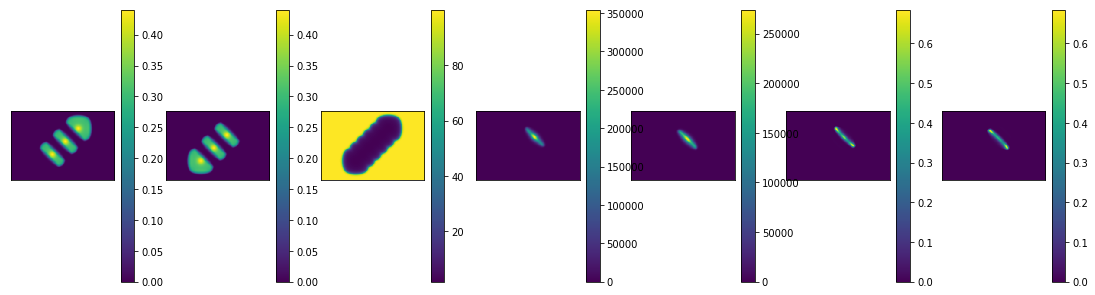

In [8]:
# Take a look at one frame
out = out.reshape((t_points,species,n_h,n_w))

print(out.shape)

plt.close('all')
fig, axs = plt.subplots(1,species, figsize=(19,5))
for i in np.arange(species):
    ax = axs[i]
    img = ax.imshow(out[-1,i,:,:], interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = fig.colorbar(mappable=img, ax=ax)
plt.show()

In [5]:
# Try out FunctionAnimation approach
import gc

plt.close('all')

t = np.linspace(0,tmax,t_points)
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes()
im_arr = out[::np.int(len(t)/300),:,:,:]
gc.collect()
t, s, h, w = im_arr.shape
blank_array = np.zeros(im_arr[-1, 0, :, :].shape)
vmax = im_arr[:,0,:,:].max()
vmin = im_arr[:,0,:,:].min()
im = plt.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none')

# initialization function: plot the background of each frame
def init():
    im.set_array(blank_array)
    return im,

# animation function.  This is called sequentially
def animate(i):
    im.set_array(im_arr[i, rhli_i, :, :])
    return im,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = anm.FuncAnimation(fig, animate, interval=50)


# Set up formatting for the movie files
#Writer = anm.writers['ffmpeg_file']
#writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=900, extra_args=['-vcodec', 'libx264'])

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
#anim.save('basic_animation.mp4', extra_args=['-vcodec', 'libx264'], dpi=50, writer=writer)
plt.close('all')


#anim.save('basic_animation.mp4', writer=writer)
#plt.close('all')

HTML(anim.to_html5_video())